In [1]:
import pandas as pd
import numpy as np
import math

import networkx as nx

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import glob
import pickle

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit

In [2]:
sns.set()
matplotlib.rcParams["figure.figsize"] = [12, 10]

### import data

In [3]:
files = sorted(glob.glob("output_data/*.csv"))

In [4]:
def get(nth):

    df = pd.read_csv(files[nth])
    if "Unnamed: 0" in df.columns:
        return df.drop("Unnamed: 0", axis=1)
    return df

In [6]:
{i: f for i, f in enumerate(files)}

{0: 'output_data/all_articles.csv',
 1: 'output_data/all_hyperlink_edges.csv',
 2: 'output_data/category_data.csv',
 3: 'output_data/category_edges.csv',
 4: 'output_data/field_dummies.csv',
 5: 'output_data/randomized_field_coeff_matrix.csv',
 6: 'output_data/randomized_field_data.csv',
 7: 'output_data/randomized_field_link_matrix.csv',
 8: 'output_data/randomized_field_links.csv',
 9: 'output_data/randomized_hyperlink_edges.csv',
 10: 'output_data/randomized_node_data.csv',
 11: 'output_data/randomized_reg_df.csv',
 12: 'output_data/wiki_all_hyperlink_edges.csv',
 13: 'output_data/wiki_field_coeff_matrix.csv',
 14: 'output_data/wiki_field_data.csv',
 15: 'output_data/wiki_field_link_matrix.csv',
 16: 'output_data/wiki_field_links.csv',
 17: 'output_data/wiki_hyperlink_edges.csv',
 18: 'output_data/wiki_node_data.csv',
 19: 'output_data/wiki_reg_df.csv'}

In [7]:
rand_edges = get(9).values

In [19]:
wiki_edges = get(17).values

In [23]:
randomized_df = get(10)

In [48]:
filtered = get(18)

In [59]:
fields = get(6)[["large_field", "field", "n_articles", "weighted_articles", "rel_size"]]

In [49]:
field_dummies = get(4).set_index("node").sort_index()

### build network

In [62]:
g = nx.DiGraph()

In [63]:
g.add_nodes_from(set(filtered["node"]))

In [64]:
g.add_edges_from(edges)

In [65]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 39710
Number of edges: 287725
Average in degree:   7.2457
Average out degree:   7.2457


### degree-preserving randomization

In [33]:
filtered = (
    filtered.sort_values("node")
    .reset_index(drop=True)
    .merge(
        filtered.sort_values("node")
        .drop_duplicates("node")
        .reset_index(drop=True)
        .reset_index()[["index", "node"]],
        on="node",
    )
)

In [35]:
in_degrees = filtered.drop_duplicates("node")["in_degree"].values

In [36]:
out_degrees = filtered.drop_duplicates("node")["out_degree"].values

In [71]:
joint_degrees = (
    filtered.loc[filtered["out_degree"] != 0]
    .groupby("out_degree")
    .apply(
        lambda df: pd.Series(
            [
                g.in_degree(n)
                for n in sum([list(g.successors(n)) for n in df["node"].unique()], [])
            ]
        )
        .value_counts()
        .to_dict()
    )
    .to_dict()
)

In [77]:
joint_rand_g = nx.directed_joint_degree_graph(in_degrees, out_degrees, joint_degrees, seed=0)

In [78]:
print(nx.info(joint_rand_g))

Name: 
Type: DiGraph
Number of nodes: 39710
Number of edges: 287725
Average in degree:   7.2457
Average out degree:   7.2457


In [231]:
rand_edges = list(joint_rand_g.edges())

In [214]:
pd.DataFrame(rand_edges, columns=["from", "to"]).to_csv(
    "output_data/randomized_hyperlink_edges.csv"
)

In [217]:
randomized_df = filtered[
    ["index", "field", "category", "node", "title", "color"]
].merge(
    pd.DataFrame.from_dict(dict(joint_rand_g.in_degree()), orient="index")
    .rename(columns={0: "in_degree"})
    .merge(
        pd.DataFrame.from_dict(dict(joint_rand_g.out_degree()), orient="index").rename(
            columns={0: "out_degree"}
        ),
        left_index=True,
        right_index=True,
    ),
    left_on="index",
    right_index=True,
)

### add network attributes

In [103]:
def neighbor_connectivity(node, graph, weighted, directed):

    w = "weight" if weighted else None

    if directed:
        arr = np.array(
            [
                graph.in_degree(n, weight=w) + graph.out_degree(n, weight=w)
                for n in list(graph.successors(node)) + list(graph.predecessors(node))
            ]
        )

    else:

        arr = np.array([graph.degree(n, weight=w) for n in list(graph.neighbors(node))])

    if arr.shape[0] == 0:
        return 0
    return arr.mean()

In [104]:
def clustering(node, graph):
    
    return nx.clustering(graph, node)

In [105]:
randomized_df = randomized_df.merge(
    randomized_df[["index"]]
    .drop_duplicates()
    .assign(
        neighbor_conn=lambda df: df["index"].apply(
            neighbor_connectivity, args=(joint_rand_g, False, True)
        ),
        clustering=lambda df: df["index"].apply(clustering, graph=joint_rand_g),
    ),
    on="index",
)

### describe fields

In [51]:
randomized_field_links = (
    (
        pd.DataFrame(rand_edges, columns=["from", "to"])
        .merge(
            randomized_df[["index", "field"]].drop_duplicates(),
            left_on="from",
            right_on="index",
        )
        .drop("index", axis=1)
        .rename(columns={"field": "edge_from"})
        .merge(
            randomized_df[["index", "field"]].drop_duplicates(),
            left_on="to",
            right_on="index",
        )
        .drop("index", axis=1)
        .rename(columns={"field": "edge_to"})
    )
    .groupby(["from", "to"])
    .apply(lambda df: df.assign(weight=1 / df.shape[0]))
    .reset_index(drop=True)
)

In [52]:
randomized_df = (
    randomized_df.merge(
        pd.DataFrame(
            randomized_field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["from", "edge_from"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "from": "index",
                "edge_from": "field",
                "weight": "within_field_out_degree",
            }
        ),
        how="left",
        on=["index", "field"],
    )
    .merge(
        pd.DataFrame(
            randomized_field_links.loc[lambda df: df["edge_from"] == df["edge_to"]]
            .groupby(["to", "edge_to"])["weight"]
            .sum()
        )
        .reset_index()
        .rename(
            columns={
                "to": "index",
                "edge_to": "field",
                "weight": "within_field_in_degree",
            }
        ),
        how="left",
        on=["index", "field"],
    )
    .fillna(0)
)

In [53]:
randomized_field_link_matrix = randomized_field_links.pivot_table(
    columns="edge_to", index="edge_from", values="weight", aggfunc="sum"
)

In [61]:
fields = fields.assign(
    ext_citations=fields["field"].apply(
        lambda f: (
            randomized_field_link_matrix.loc[:, f].sum()
            - randomized_field_link_matrix.loc[f, f]
        )
    )
).assign(
    rel_ext_use=lambda df: df["ext_citations"]
    / randomized_field_link_matrix.sum().sum()
    * (1 - fields["rel_size"])
    / fields["rel_size"],
    ext_cit_avg=lambda df: df["ext_citations"] / fields["weighted_articles"],
    imp_exp_ratio=lambda df: df["ext_citations"]
    / fields["field"].apply(
        lambda f: (
            randomized_field_link_matrix.loc[f].sum()
            - randomized_field_link_matrix.loc[f, f]
        )
    ),
)

In [62]:
fields = fields.merge(
    pd.DataFrame(randomized_field_links.groupby("edge_from")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_from": "field", "weight": "field_out_degree"}),
    on="field",
).merge(
    pd.DataFrame(randomized_field_links.groupby("edge_to")["weight"].sum())
    .reset_index()
    .rename(columns={"edge_to": "field", "weight": "field_in_degree"}),
    on="field",
)

#### save all

In [63]:
randomized_df.to_csv("output_data/randomized_node_data.csv")

In [64]:
fields.to_csv("output_data/randomized_field_data.csv")

In [65]:
randomized_field_links.to_csv("output_data/randomized_field_links.csv")

In [66]:
randomized_field_link_matrix.to_csv("output_data/randomized_field_link_matrix.csv")

Text(0.5, 1.0, 'Distribution of hyperlinks between fields in randomized network\n')

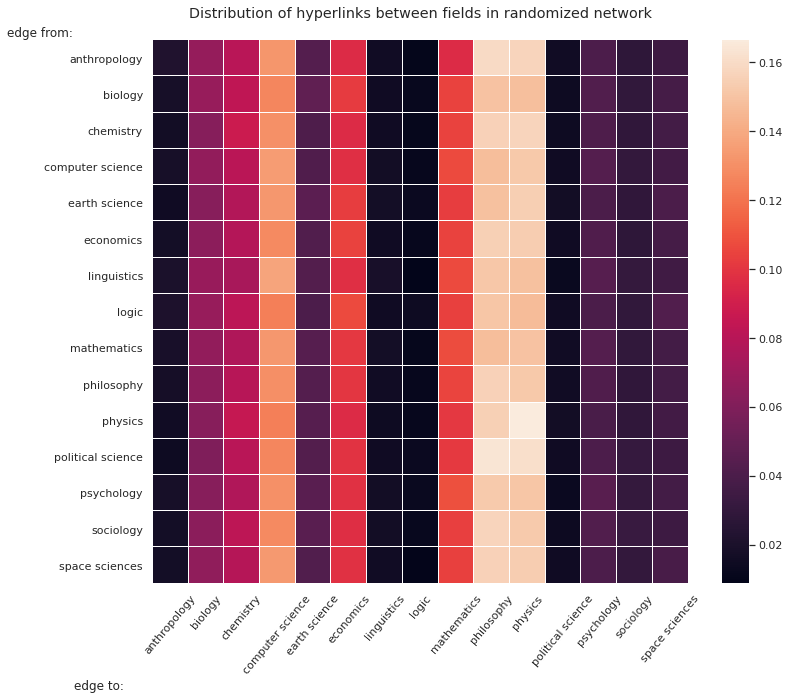

In [67]:
fig, ax = plt.subplots()
ax.set_facecolor("black")

sns.heatmap(
    randomized_field_link_matrix.div(randomized_field_link_matrix.sum(axis=1), axis=0),
    linewidths=0.01,
)
plt.xlabel("edge to:", position=(-0.1, 0))
plt.xticks(rotation=50)
plt.ylabel("edge from:", rotation=0, position=(0, 1))
plt.title(
    "Distribution of hyperlinks between fields in randomized network\n",
    fontsize="large",
)

In [68]:
def fields_bar_chart(attr, title, ylim=None, annot=True):

    sorted_fields = fields.sort_values(attr, ascending=False)

    plt.bar(
        sorted_fields["field"].values,
        sorted_fields[attr].values,
        color=sns.cubehelix_palette(fields.shape[0]),
    )

    plt.xticks(rotation=30)
    
    if ylim:
        plt.ylim(0, ylim)

    if annot:
        for idx, r in enumerate(sorted_fields[attr]):
            plt.text(x=idx - 0.25, y=1.01 * r, s=round(r, 2), size=12)

    plt.title(title, fontsize="x-large")

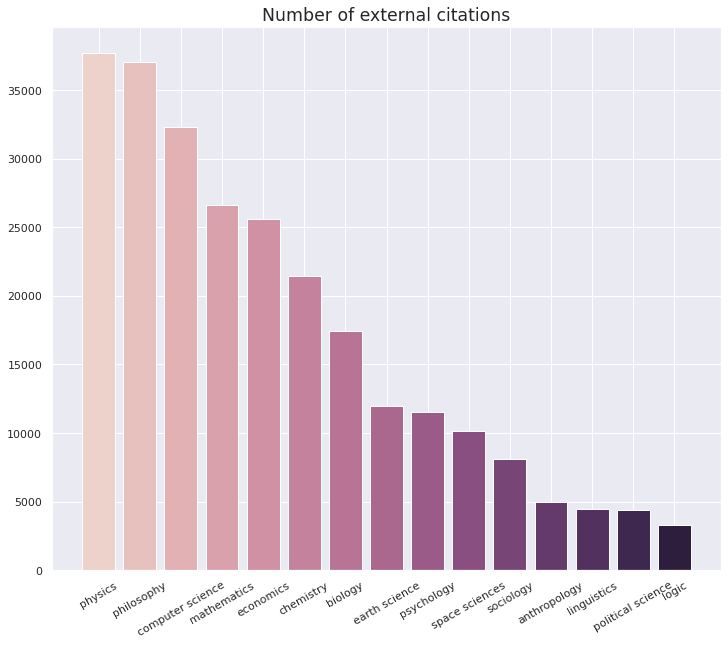

In [71]:
fields_bar_chart("ext_citations", "Number of external citations", annot=False)

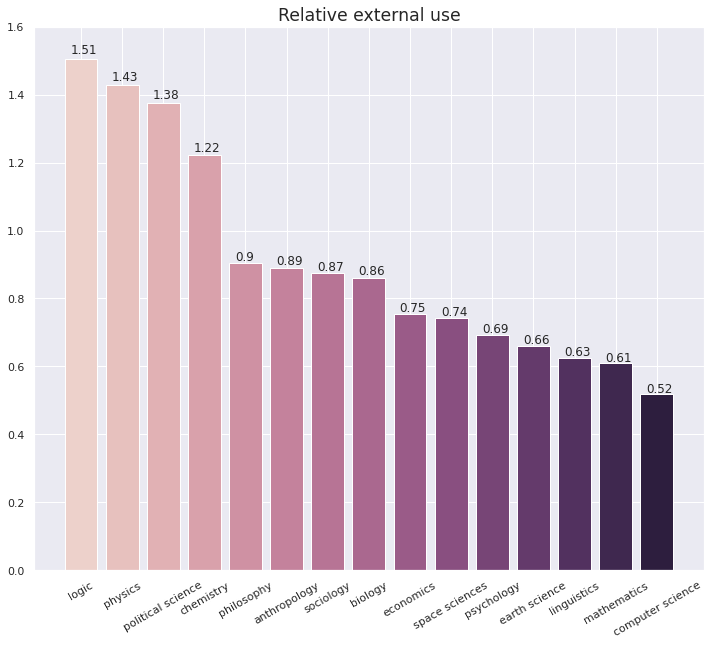

In [85]:
fields_bar_chart("rel_ext_use", "Relative external use", ylim=1.6)

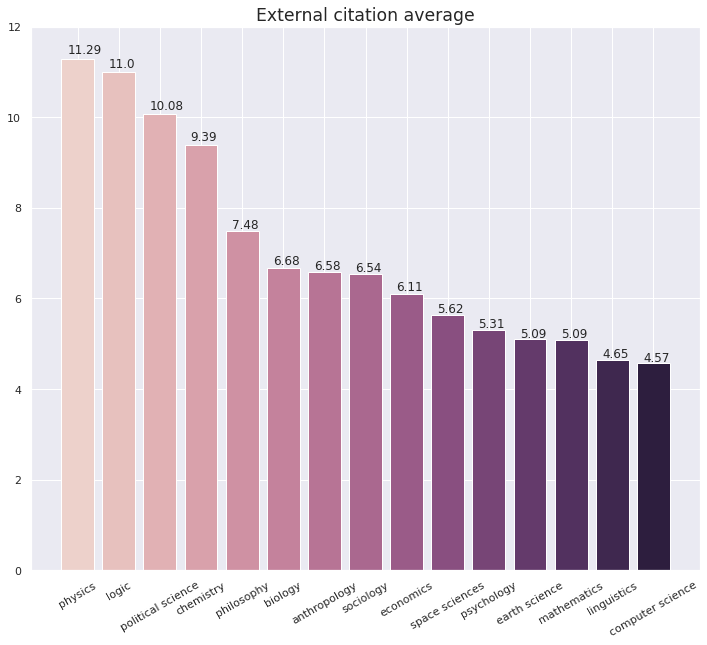

In [86]:
fields_bar_chart("ext_cit_avg", "External citation average", ylim=12)

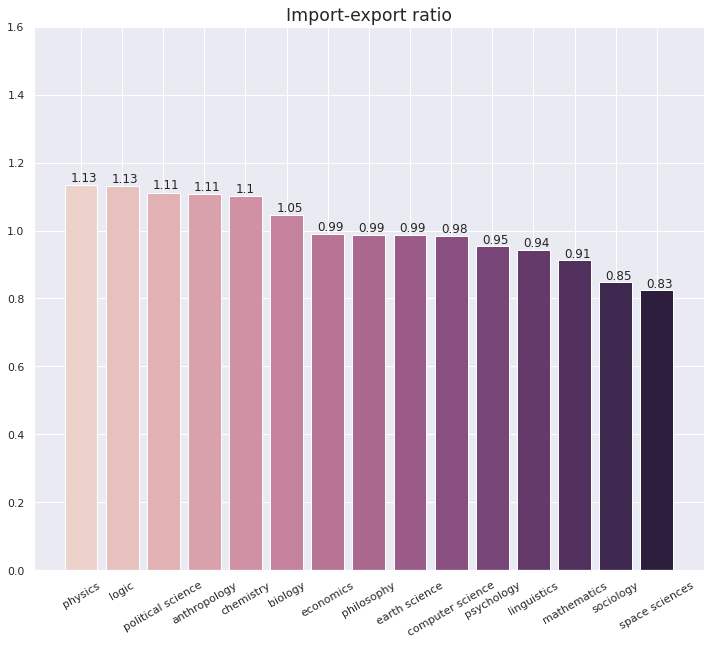

In [87]:
fields_bar_chart("imp_exp_ratio", "Import-export ratio", 1.6)

### predicting field with network attributes

In [72]:
reg_df = (
    randomized_df.drop_duplicates(["node", "field"])
    .groupby("node")
    .mean()
    .assign(
        p_within_field_in=lambda df: df["within_field_in_degree"] / df["in_degree"],
        p_within_field_out=lambda df: df["within_field_out_degree"] / df["out_degree"],
    )
    .fillna(0)
    .drop(
        ["index", "in_degree", "within_field_out_degree", "within_field_in_degree"],
        axis=1,
    )
)

In [73]:
reg_df.to_csv("output_data/randomized_reg_df.csv")

In [74]:
X = pd.DataFrame(
    StandardScaler().fit_transform(reg_df), columns=reg_df.columns, index=reg_df.index,
).assign(const=1)

In [75]:
reg_metrics = {}

In [76]:
def logit_model(target_var):

    y = field_dummies.sort_values("node")[target_var]

    logit = Logit(y, X).fit()
    prediction = logit.predict(X)

    false_pos, true_pos, tresholds = metrics.roc_curve(y, prediction)
    auc = metrics.roc_auc_score(y, prediction)
    prec, rec, tresholds = metrics.precision_recall_curve(y, prediction)

    reg_metrics.update(
        {
            target_var: {
                "false_pos": false_pos,
                "true_pos": true_pos,
                "auc": auc,
                "prec": prec,
                "rec": rec,
            }
        }
    )
    
    return pd.DataFrame(
        [logit.params.rename("coeffs"), logit.pvalues.rename("p")]
    ).assign(field=target_var)

In [77]:
all_results = pd.concat(
    [logit_model(field) for field in fields["field"]]
)

Optimization terminated successfully.
         Current function value: 0.466587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050994
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.413708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.255686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.301721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.095759
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120993


In [78]:
with open("output_data/randomized_reg_metrics.p", "wb") as fp:
    pickle.dump(reg_metrics, fp)

In [79]:
randomized_field_coeff_matrix = (
    all_results.groupby("field")
    .apply(
        lambda df: df.loc["coeffs"]
        * (0.01 > df.loc["p"]).astype(int).replace(0, np.nan)
    )
    .drop("const", axis=1)
)

In [80]:
randomized_field_coeff_matrix.to_csv("output_data/randomized_field_coeff_matrix.csv")

Text(0.5, 1.0, 'Regression parameters by field and variable\n(randomized network)\n')

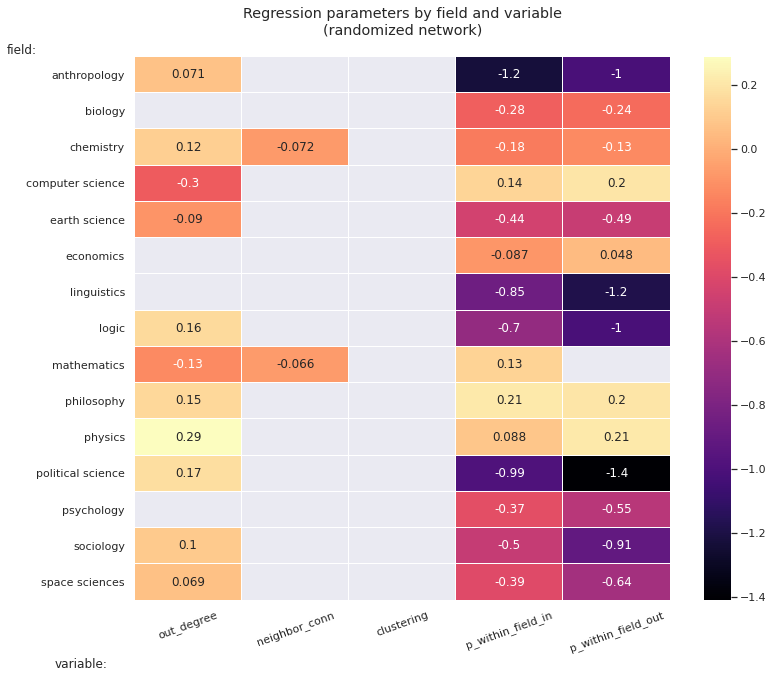

In [81]:
sns.heatmap(randomized_field_coeff_matrix, cmap="magma", annot=True, linewidth=0.01)
plt.xticks(rotation=20)
plt.ylabel("field:", rotation=0, position=(0, 1))
plt.xlabel("variable:", position=(-0.1, 0))
plt.title(
    "Regression parameters by field and variable\n(randomized network)\n",
    fontsize="large",
)

Text(0, 0.5, 'True positives')

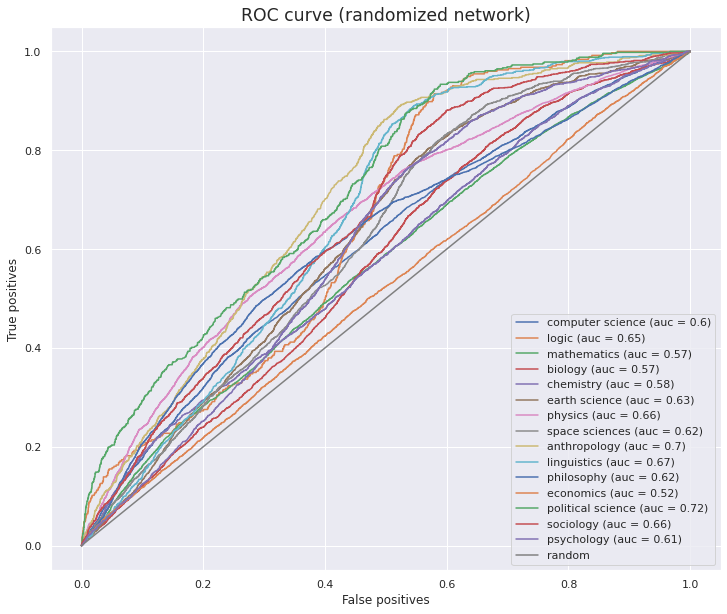

In [83]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["false_pos"],
        reg_metrics[f]["true_pos"],
        label="{} (auc = {})".format(f, reg_metrics[f]["auc"].round(2)),
    )

plt.plot(np.linspace(0, 1), np.linspace(0, 1), c="grey", label="random")
plt.legend(loc=4)
plt.title("ROC curve (randomized network)", fontsize="x-large")
plt.xlabel("False positives")
plt.ylabel("True positives")

Text(0, 0.5, 'Recall')

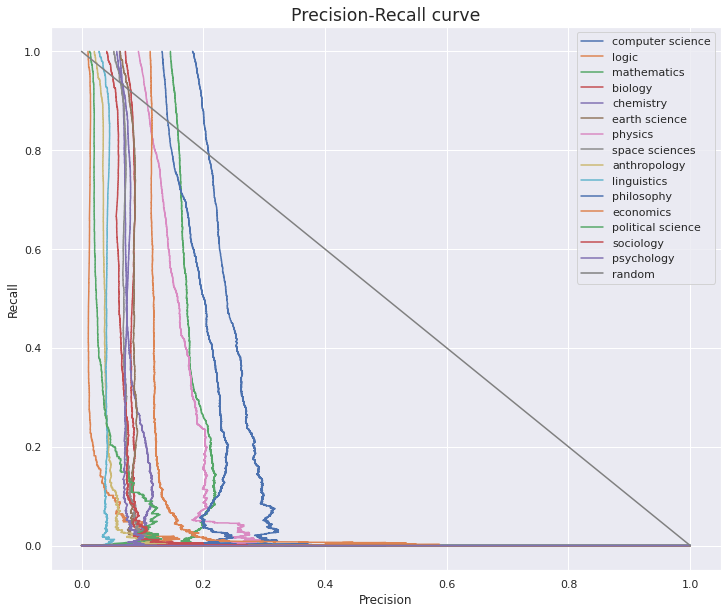

In [84]:
for f in reg_metrics.keys():

    plt.plot(
        reg_metrics[f]["prec"], reg_metrics[f]["rec"], label=f,
    )

plt.plot(np.linspace(0, 1), 1 - np.linspace(0, 1), c="grey", label="random")

plt.legend(loc=1)
plt.title("Precision-Recall curve", fontsize="x-large")
plt.xlabel("Precision")
plt.ylabel("Recall")